# Multi-label text classification using BERT

## Imports

In [1]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from collections import defaultdict

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW, CamembertTokenizer, CamembertModel

from defi_textmine_2025.data.utils import load_test_raw_data
from defi_textmine_2025.data.utils import TARGET_COL, INTERIM_DIR, MODELS_DIR, submission_path
from defi_textmine_2025.pytorch_bert_dataset_and_model import LinearHeadBertBasedModel, loss_fn

BASE_CHECKPOINT = "camembert/camembert-base"
EMBEDDING_SIZE = 768 # 1024
TASK_NAME = "multilabel_tagged_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}
categories_to_check = ['END_DATE', 'GENDER_MALE', 'WEIGHS', 'DIED_IN', 'HAS_FAMILY_RELATIONSHIP', 'IS_DEAD_ON', 'IS_IN_CONTACT_WITH', 'HAS_CATEGORY', 'HAS_CONTROL_OVER', 'IS_BORN_IN', 'IS_OF_SIZE', 'HAS_LATITUDE', 'IS_PART_OF', 'IS_OF_NATIONALITY', 'IS_COOPERATING_WITH', 'DEATHS_NUMBER', 'HAS_FOR_HEIGHT', 'INITIATED', 'WAS_DISSOLVED_IN', 'HAS_COLOR', 'CREATED', 'IS_LOCATED_IN', 'WAS_CREATED_IN', 'IS_AT_ODDS_WITH', 'HAS_CONSEQUENCE', 'HAS_FOR_LENGTH', 'INJURED_NUMBER', 'START_DATE', 'STARTED_IN', 'GENDER_FEMALE', 'HAS_LONGITUDE', 'RESIDES_IN', 'HAS_FOR_WIDTH', 'IS_BORN_ON', 'HAS_QUANTITY', 'OPERATES_IN', 'IS_REGISTERED_AS']

mlb = MultiLabelBinarizer()
mlb.fit([categories_to_check])
logging.info(f"{mlb.classes_=}")

generated_data_dir_path = os.path.join(INTERIM_DIR, "multilabel_tagged_text_dataset")
assert os.path.exists(generated_data_dir_path)

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_multilabel_tagged_text_dataset")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {labeled_preprocessed_data_dir_path}

model_dir_path = os.path.join(MODELS_DIR, f"finetuned-{BASE_CHECKPOINT}")
! mkdir -p {model_dir_path}
model_dict_state_path = os.path.join(model_dir_path,"MLTC_model_state.bin")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

[05:31:15|INFO|481007277.py:44] mlb.classes_=array(['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE',
       'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE',
       'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT',
       'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE',
       'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH',
       'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON',
       'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY',
       'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN',
       'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN',
       'WAS_DISSOLVED_IN', 'WEIGHS'], dtype=object)


device(type='cuda')

In [2]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)

def process_data(data: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([data, pd.DataFrame(mlb.transform(data[TARGET_COL]), columns=mlb.classes_, index=data.index)], axis=1) # .drop([TARGET_COL], axis=1)


def format_relations_str_to_list(labels_as_str: str) -> List[str]:
    return json.loads(
        labels_as_str.replace("{", "[").replace("}", "]").replace("'", '"')
    )  if not pd.isnull(labels_as_str) else []


def process_csv_to_csv(in_dir_or_file_path: str, out_dir_path: str) -> None:
    """Convert labels, i.e. list of relations category, into one-hot vectors

    Args:
        in_dir_or_file_path (str): str
        out_dir_path (str): str
    """
    if os.path.isdir(in_dir_or_file_path):
        all_files = glob.glob(os.path.join(in_dir_or_file_path , "*.csv"))  
    else:
        assert in_dir_or_file_path.endswith(".csv")
        all_files = [in_dir_or_file_path]
    for filename in (pb:=tqdm(all_files)):
        pb.set_description(filename)
        preprocessed_data_filename = os.path.join(out_dir_path, os.path.basename(filename))
        process_data(load_csv(filename).assign(**{TARGET_COL: lambda df: df[TARGET_COL].apply(format_relations_str_to_list)})).to_csv(preprocessed_data_filename, sep="\t")

## Preprocess and save data

- load generated data
- convert to dataframe
- convert categories into one-hot labels
- save into a tsv file

In [3]:
process_csv_to_csv(os.path.join(generated_data_dir_path, "train"), labeled_preprocessed_data_dir_path)

data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/train/41884.csv: 100%|██████████| 800/800 [00:04<00:00, 179.57it/s]


## Load preprocessed data

In [4]:
labeled_df = load_csv(labeled_preprocessed_data_dir_path, index_col=0, sep='\t')

In [5]:
labeled_df

,text_index,e1,e2,text,relations,CREATED,DEATHS_NUMBER,DIED_IN,END_DATE,GENDER_FEMALE,...,IS_OF_SIZE,IS_PART_OF,IS_REGISTERED_AS,OPERATES_IN,RESIDES_IN,STARTED_IN,START_DATE,WAS_CREATED_IN,WAS_DISSOLVED_IN,WEIGHS
0,2576,0,0,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2576,1,0,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2576,0,1,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2576,1,1,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2576,2,0,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,41884,11,22,"Le 14 janvier 2014, en pleine Sibérie, dans un...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124001,41884,12,22,"Le 14 janvier 2014, en pleine Sibérie, dans un...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124002,41884,15,22,"Le 14 janvier 2014, en pleine Sibérie, dans un...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124003,41884,17,22,"Le 14 janvier 2014, en pleine Sibérie, dans un...",['HAS_COLOR'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Validation split

- split such that each category exist at least in the train dataset

In [6]:
mlb.classes_

array(['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE',
       'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE',
       'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT',
       'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE',
       'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH',
       'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON',
       'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY',
       'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN',
       'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN',
       'WAS_DISSOLVED_IN', 'WEIGHS'], dtype=object)

In [9]:
df_train, df_valid = train_test_split(labeled_df, test_size = 0.2, shuffle=True, random_state=42)
df_train.shape, df_valid.shape

((99204, 42), (24801, 42))

In [10]:
pd.DataFrame({"train": df_train[mlb.classes_].sum(axis=0), "valid": df_valid[mlb.classes_].sum(axis=0)}).sort_values("train", ascending=False)

,train,valid
IS_LOCATED_IN,7237,1788
HAS_CONTROL_OVER,3631,916
IS_IN_CONTACT_WITH,2324,595
OPERATES_IN,1914,521
STARTED_IN,1512,348
IS_AT_ODDS_WITH,1224,302
IS_PART_OF,1157,305
START_DATE,837,197
GENDER_MALE,723,185
HAS_CATEGORY,705,189


In [11]:
df_train_with_relation = df_train[df_train[mlb.classes_].sum(axis=1) >= 1]
df_train_with_relation.shape

(21030, 42)

In [12]:
df_train_without_relation = df_train[df_train[mlb.classes_].sum(axis=1) == 0]
df_train_without_relation.shape

(78174, 42)

## Create the tokenized datasets for model input

In [13]:
# Hyperparameters
MAX_LEN = 300 # TODO: increase
# tokenizer = BertTokenizer.from_pretrained(BASE_CHECKPOINT)
tokenizer = CamembertTokenizer.from_pretrained(BASE_CHECKPOINT)
task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [
    f"<{entity_class}>" for entity_class in entity_classes
]
# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


59

In [14]:
# Test the tokenizer
test_text = "La <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>police</e2> tchèque a <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>mis la main</e2> sur le couple responsable d'un trafic d'œuvres d'art. Il s'agit de <e1><TERRORIST_OR_CRIMINAL>Patel</e1> et Mirna Maroski. Une <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>perquisition</e2> à leur domicile a permis de retrouver une centaine de tableaux d'artistes européens. Il y avait également des pots en céramique et en porcelaine d'origine chinoise, ainsi que plusieurs faux documents de voyage. Les époux Maroski ont été conduits au poste de <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>police</e2> dans un véhicule blindé. Mirna Maroski s'est évanouie une fois arrivée au poste. Elle a été amenée en ambulance au CHU de Motol où elle a été soignée. Monsieur Sergueï Alekseï, le directeur de l'hôpital, a demandé à ses collaborateurs d'être vigilants et de ne pas se laisser corrompre par la criminelle."
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = MAX_LEN,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[    5,    61, 32007, 32040,  1642, 32008, 17499,    33, 32007, 32040,
           467,    13,   489, 32008,    32,    16,  1145,  1295,    18,    11,
            59,  3893,    18,    11,  2172,    10,    18,    11,   559,     9,
            69,    52,    11,   567,     8, 32005, 32011,  4844,   647, 32006,
            14, 11962,   778,  1525,   189,  5812,     9,   180, 32007, 32040,
         27417, 32008,    15,    97,  1711,    33,   994,     8,  1008,    28,
          6848,     8,  5705,    18,    11, 10407,  3980,     9,    69,   102,
           171,   200,    20, 13035,    22,  9504,    14,    22, 17533,    18,
            11,   870,  7880,     7,   163,    27,   247,  2601,  1801,     8,
           805,     9,    74,  9493,  1525,   189,  5812,    96,   101,  2653,
            10,    36,  1337,     8, 32007, 32040,  1642, 32008,    29,    23,
          1690, 25062,     9, 11962,   778,  1525,   189,  5812,    52,    11,
            41, 11506,   364,  3903,  

In [15]:
tokenizer.batch_decode(encodings['input_ids'])

["<s>La <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> police </e2> tchèque a <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> mis la main </e2> sur le couple responsable d'un trafic d'œuvres d'art. Il s'agit de <e1> <TERRORIST_OR_CRIMINAL> Patel </e1> et Mirna Maroski. Une <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> perquisition </e2> à leur domicile a permis de retrouver une centaine de tableaux d'artistes européens. Il y avait également des pots en céramique et en porcelaine d'origine chinoise, ainsi que plusieurs faux documents de voyage. Les époux Maroski ont été conduits au poste de <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> police </e2> dans un véhicule blindé. Mirna Maroski s'est évanouie une fois arrivée au poste. Elle a été amenée en ambulance au CHU de Motol où elle a été soignée. Monsieur Sergueï Alekseï, le directeur de l'hôpital, a demandé à ses collaborateurs d'être vigilants et de ne pas se laisser corrompre par la criminelle.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [16]:
len(tokenizer)

32064

In [17]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        # self.e1 = list(df['e1'])
        # self.e1 = list(df['e1'])
        # self.text_indexes = list(df['text_index'])
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        text = str(self.title[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': text,
            # 'text_index': self.text_index[index],
            # 'e1': self.e1[index],
            # 'e2': self.e2[index],
        }

In [18]:
# most_common_categories = df_train[mlb.classes_].sum().sort_values(ascending=False).index[:7]
# logging.info(most_common_categories)
# # target_list = mlb.classes_.tolist()
# target_list = most_common_categories
target_list = mlb.classes_
logging.info(f"{len(target_list)} categories = {target_list}")

[05:31:23|INFO|1100424365.py:6] 37 categories = ['CREATED' 'DEATHS_NUMBER' 'DIED_IN' 'END_DATE' 'GENDER_FEMALE'
 'GENDER_MALE' 'HAS_CATEGORY' 'HAS_COLOR' 'HAS_CONSEQUENCE'
 'HAS_CONTROL_OVER' 'HAS_FAMILY_RELATIONSHIP' 'HAS_FOR_HEIGHT'
 'HAS_FOR_LENGTH' 'HAS_FOR_WIDTH' 'HAS_LATITUDE' 'HAS_LONGITUDE'
 'HAS_QUANTITY' 'INITIATED' 'INJURED_NUMBER' 'IS_AT_ODDS_WITH'
 'IS_BORN_IN' 'IS_BORN_ON' 'IS_COOPERATING_WITH' 'IS_DEAD_ON'
 'IS_IN_CONTACT_WITH' 'IS_LOCATED_IN' 'IS_OF_NATIONALITY' 'IS_OF_SIZE'
 'IS_PART_OF' 'IS_REGISTERED_AS' 'OPERATES_IN' 'RESIDES_IN' 'STARTED_IN'
 'START_DATE' 'WAS_CREATED_IN' 'WAS_DISSOLVED_IN' 'WEIGHS']


In [19]:
df_train.shape, df_valid.shape

((99204, 42), (24801, 42))

In [20]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)

In [21]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([    5,  2445,  8666,   185, 12686,     7,  1328,     8,    17,    12,
          1289, 15686,  3985,  3569,     7,    23,  2422,    12,    12,    36,
          9834,     7,    33,   101, 20867,    15,    28,  2207, 26540,    29,
            16,   161,    26,  2837,     8,    17,    12,  4771,    18,    12,
            59,    20,   580,     8,    17,    12,  1289,     9,    61,  2207,
          9082,    32,    19,    21, 14922,    10, 19331,    10,    20, 19867,
            31,    52, 15447,   176,   193,   274,    29,    16,   256,     9,
            74,  7574,   530,  8836,    10,     8, 14611,     7,     8,  2970,
             7,     8, 32005, 32019, 12817,    10, 32006,    21,     7,    20,
         27825,    10,    14,     8,   587,   867,    24,  2748,    20, 14613,
            10,    14,    19,  8139, 32007, 32055,    36,   307,     8,    13,
           656, 32008,    21,     9,   436,    96, 11952,     8,   187,  2321,
            14, 18085,    10,    66,   

## Create data loaders

In [22]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 32

# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

## Compute class weights to handle imbalance into the loss function

In [23]:
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
n_examples = labeled_df.shape[0]
n_classes = len(target_list)
def get_cat_var_distribution(cat_var: pd.Series) -> pd.DataFrame:
    return pd.concat(
        [cat_var.value_counts(), cat_var.value_counts(normalize=True)], axis=1
    )
def compute_class_weights(lbl_df: pd.DataFrame, class_names: list) -> pd.Series:
    return lbl_df[target_list].sum(axis=0).map(lambda x: (1 / x) * (n_examples / n_classes)).rename("weight")

class_weights = compute_class_weights(labeled_df, target_list)
class_weights_tensor = torch.Tensor(class_weights.values).to(device, dtype = torch.float16)

pd.concat([labeled_df[target_list].sum(axis=0).rename("class_size"), class_weights], axis=1)

,class_size,weight
CREATED,126,26.599099
DEATHS_NUMBER,75,44.686486
DIED_IN,41,81.743573
END_DATE,874,3.834653
GENDER_FEMALE,414,8.095378
GENDER_MALE,908,3.691064
HAS_CATEGORY,894,3.748866
HAS_COLOR,91,36.829522
HAS_CONSEQUENCE,769,4.358240
HAS_CONTROL_OVER,4547,0.737076


## Prepare the model to trained

In [24]:
model = LinearHeadBertBasedModel(
    tokenizer=tokenizer,
    embedding_model=CamembertModel.from_pretrained(BASE_CHECKPOINT, return_dict=True),
    embedding_size=EMBEDDING_SIZE,
    n_classes=len(target_list),
)

# Freezing BERT layers: (tested, weaker convergence)
# for param in model.embedding_model.parameters():
#     param.requires_grad = False

model.to(device)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


LinearHeadBertBasedModel(
  (embedding_model): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32064, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

In [25]:
# # BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# # This version is more numerically stable than using a plain Sigmoid followed 
# # by a BCELoss as, by combining the operations into one layer, 
# # we take advantage of the log-sum-exp trick for numerical stability.
# def loss_fn(outputs, targets):
#     return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [26]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5, weight_decay=0.1)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Function to tain the model

In [27]:
# Training of the model for one epoch
def train_model(model, training_loader, optimizer, _class_weights_tensor):
    predictions = []
    prediction_probs = []
    target_values = []
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate dropout, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,37)
        loss = loss_fn(outputs, targets, _class_weights_tensor)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        # outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        # targets = targets.cpu().detach().numpy()
        # correct_predictions += np.sum(outputs==targets)
        # num_samples += targets.size   # total number of elements in the 2D array
        outputs = torch.sigmoid(outputs).cpu().detach()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.cpu().detach()
        correct_predictions += np.sum(preds.numpy()==targets.numpy())
        num_samples += targets.numpy().size   # total number of elements in the 2D array
        
        # thresholding at 0.5
        preds = outputs.round()        
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()
        # Update progress bar
        loop.set_description(f"")
        loop.set_postfix(batch_loss=loss.cpu().detach().numpy())

    # returning: trained model, model accuracy, mean loss
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)    

    return model, float(correct_predictions)/num_samples, f1_score(target_values, predictions, average="macro", zero_division=0), np.mean(losses)
    # return model, float(correct_predictions)/num_samples, np.mean(losses)

# torch.cuda.empty_cache()
# train_model(model, train_data_loader, optimizer, class_weights_tensor)

## Function to evaluate the model

In [28]:
def eval_model(model, validation_loader, _class_weights_tensor):    
    predictions = []
    prediction_probs = []
    target_values = []
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        # for batch_idx, data in tqdm(enumerate(validation_loader, 0), "evaluating"):
        for data in tqdm(validation_loader, "evaluating"):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets, _class_weights_tensor)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach()
            # thresholding at 0.5
            preds = outputs.round()
            targets = targets.cpu().detach()
            correct_predictions += np.sum(preds.numpy()==targets.numpy())
            num_samples += targets.numpy().size   # total number of elements in the 2D array

            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targets)
            # break
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)    

    return float(correct_predictions)/num_samples, f1_score(target_values, predictions, average="macro", zero_division=0), np.mean(losses)


# eval_model(model, train_data_loader, class_weights_tensor)

## Function to apply the model

In [29]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in tqdm(data_loader, "training"):
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
        # break
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

# get_predictions(model, train_data_loader)

## Model Training

In [30]:
EPOCHS = 40
# THRESHOLD = 0.5 # threshold for the sigmoid
PATIENCE = 3
n_not_better_steps = 0
history = defaultdict(list)
best_f1_macro = 0
# assert not os.path.exists(model_dict_state_path), "The trained model is already serialized at {model_dict_state_path}"

if not os.path.exists(os.path.dirname(model_dict_state_path)):
    os.makedirs(os.path.dirname(model_dict_state_path))

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_f1_macro, train_loss = train_model(model, train_data_loader, optimizer, class_weights_tensor)
    val_acc, val_f1_macro, val_loss = eval_model(model, val_data_loader, class_weights_tensor)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_f1_macro={train_f1_macro:.4f}, val_f1_macro={val_f1_macro:.4f}')

    history['train_acc'].append(train_acc)
    history['train_f1_macro'].append(train_f1_macro)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_f1_macro'].append(val_f1_macro)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_f1_macro > best_f1_macro:
        torch.save(model.state_dict(), model_dict_state_path)
        best_f1_macro = val_f1_macro
        n_not_better_steps = 0
    else: # check for early stopping
        n_not_better_steps += 1
        if n_not_better_steps >= PATIENCE:
            break
    

Epoch 1/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:55<00:00,  4.42it/s]

train_loss=1.5879, val_loss=0.2158 train_f1_macro=0.0035, val_f1_macro=0.0000
Epoch 2/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:55<00:00,  4.43it/s]

train_loss=0.1859, val_loss=0.1755 train_f1_macro=0.0000, val_f1_macro=0.0000
Epoch 3/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:55<00:00,  4.43it/s]


train_loss=0.1632, val_loss=0.1572 train_f1_macro=0.0018, val_f1_macro=0.0016
Epoch 4/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:55<00:00,  4.43it/s]


train_loss=0.1426, val_loss=0.1334 train_f1_macro=0.0447, val_f1_macro=0.0787
Epoch 5/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:58<00:00,  4.35it/s]


train_loss=0.1183, val_loss=0.1296 train_f1_macro=0.1170, val_f1_macro=0.2302
Epoch 6/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:53<00:00,  4.47it/s]


train_loss=0.1045, val_loss=0.1224 train_f1_macro=0.2758, val_f1_macro=0.3013
Epoch 7/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:53<00:00,  4.48it/s]


train_loss=0.0874, val_loss=0.1134 train_f1_macro=0.3809, val_f1_macro=0.3707
Epoch 8/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:54<00:00,  4.44it/s]


train_loss=0.0747, val_loss=0.1105 train_f1_macro=0.4569, val_f1_macro=0.4075
Epoch 9/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [03:21<00:00,  3.86it/s]


train_loss=0.0682, val_loss=0.1185 train_f1_macro=0.5277, val_f1_macro=0.4840
Epoch 10/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [03:07<00:00,  4.13it/s]


train_loss=0.0588, val_loss=0.1204 train_f1_macro=0.5748, val_f1_macro=0.5030
Epoch 11/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [03:03<00:00,  4.24it/s]

train_loss=0.0507, val_loss=0.1087 train_f1_macro=0.6276, val_f1_macro=0.4663
Epoch 12/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:58<00:00,  4.34it/s]


train_loss=0.0450, val_loss=0.1108 train_f1_macro=0.6515, val_f1_macro=0.5072
Epoch 13/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:52<00:00,  4.49it/s]

train_loss=0.0373, val_loss=0.1210 train_f1_macro=0.6983, val_f1_macro=0.5005
Epoch 14/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:57<00:00,  4.36it/s]


train_loss=0.0353, val_loss=0.1206 train_f1_macro=0.7072, val_f1_macro=0.5308
Epoch 15/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [02:53<00:00,  4.47it/s]


train_loss=0.0330, val_loss=0.1066 train_f1_macro=0.7433, val_f1_macro=0.5848
Epoch 16/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [03:02<00:00,  4.26it/s]

train_loss=0.0311, val_loss=0.1233 train_f1_macro=0.7479, val_f1_macro=0.5409
Epoch 17/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [03:28<00:00,  3.72it/s]

train_loss=0.0288, val_loss=0.1168 train_f1_macro=0.7609, val_f1_macro=0.5703
Epoch 18/40


  0%|          | 0/6201 [00:00<?, ?it/s]

evaluating: 100%|██████████| 776/776 [03:28<00:00,  3.72it/s]

train_loss=0.0256, val_loss=0.1017 train_f1_macro=0.7814, val_f1_macro=0.5790


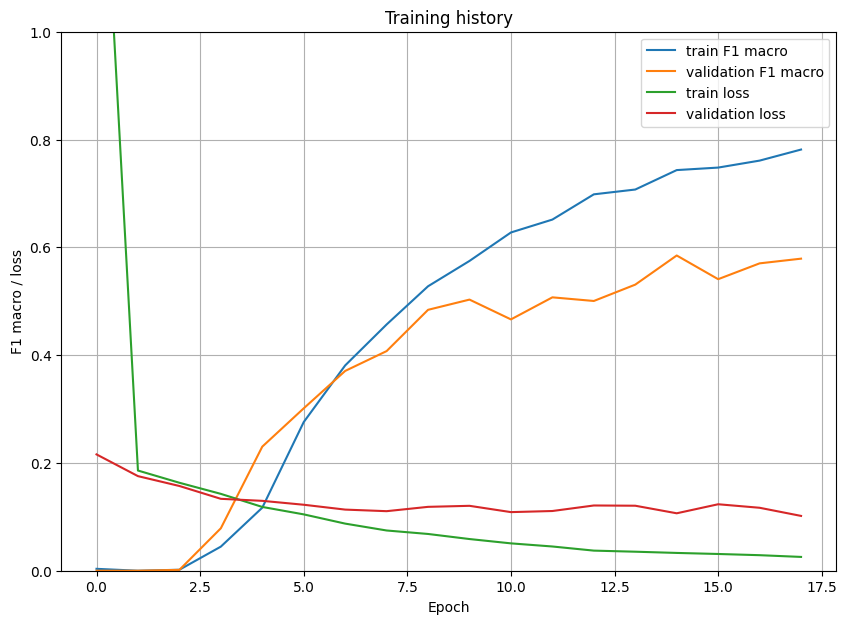

In [31]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_f1_macro'], label='train F1 macro')
plt.plot(history['val_f1_macro'], label='validation F1 macro')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('F1 macro / loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

## Evaluation of the model

In [32]:
# Loading pretrained model (best model)
# model = BERTClass(tokenizer)
model.load_state_dict(torch.load(model_dict_state_path))
model = model.to(device)

In [33]:
# Evaluate the model using the test data
# val_acc, val_f1_macro, val_loss = eval_model(val_data_loader, model)

In [34]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
# val_acc

In [35]:
titles, predictions, prediction_probs, target_values = get_predictions(model, val_data_loader)

training: 100%|██████████| 776/776 [03:23<00:00,  3.82it/s]


In [36]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list, zero_division=0))

                         precision    recall  f1-score   support

                CREATED       0.43      0.32      0.37        28
          DEATHS_NUMBER       0.42      0.74      0.54        19
                DIED_IN       1.00      0.10      0.18        10
               END_DATE       0.77      0.78      0.78       175
          GENDER_FEMALE       0.84      0.83      0.84        84
            GENDER_MALE       0.68      0.86      0.76       185
           HAS_CATEGORY       0.61      0.72      0.66       189
              HAS_COLOR       0.92      0.92      0.92        26
        HAS_CONSEQUENCE       0.77      0.65      0.70       144
       HAS_CONTROL_OVER       0.70      0.52      0.60       916
HAS_FAMILY_RELATIONSHIP       0.86      0.92      0.89        52
         HAS_FOR_HEIGHT       0.00      0.00      0.00         4
         HAS_FOR_LENGTH       0.22      0.67      0.33         3
          HAS_FOR_WIDTH       0.33      1.00      0.50         3
           HAS_LATITUDE 

In [37]:
# import seaborn as sns
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True category')
#     plt.xlabel('Predicted category');

In [38]:
# cm = confusion_matrix(target_values, predictions)
# df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
# show_confusion_matrix(df_cm)

## Prepare submission

In [39]:
df_test = load_csv(os.path.join(generated_data_dir_path, "test")) #.drop(TARGET_COL, axis=1)
df_test

,text_index,e1,e2,text,relations
0,51344,0,0,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,NaN
1,51344,0,1,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,NaN
2,51344,1,1,Un incendie a eu lieu hier matin au <e1><PLACE...,NaN
3,51344,1,2,Un incendie a eu lieu hier matin au <e1><PLACE...,NaN
4,51344,1,3,Un incendie a eu lieu hier matin au <e1><PLACE...,NaN
...,...,...,...,...,...
53877,4998,10,20,Un braquage de banque a eu lieu à New York hie...,NaN
53878,4998,11,20,Un braquage de banque a eu lieu à New York hie...,NaN
53879,4998,13,20,Un braquage de banque a eu lieu à New York hie...,NaN
53880,4998,14,20,Un braquage de banque a eu lieu à New York hie...,NaN


In [40]:
# df_test.head().drop(TARGET_COL, axis=1).assign(**{cat: [0]*df_test.head().shape[0] for cat in target_list})

In [41]:
test_dataset = CustomDataset(df_test.drop(TARGET_COL, axis=1).assign(**{cat: [0]*df_test.shape[0] for cat in target_list}), tokenizer, MAX_LEN, target_list)

In [42]:
TEST_BATCH_SIZE = 32

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [43]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

training: 100%|██████████| 1684/1684 [06:50<00:00,  4.10it/s]


In [44]:

ml_labeled_test_df = pd.concat(
    [
        df_test.drop(TARGET_COL, axis=1),
        pd.Series(
            mlb.inverse_transform(
                pd.DataFrame(predictions.numpy(), columns=target_list, index=df_test.index)[mlb.classes_].values
            ),
            name=TARGET_COL,
            index=df_test.index
        )
    ],
    axis=1
)
ml_labeled_test_df

,text_index,e1,e2,text,relations
0,51344,0,0,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,()
1,51344,0,1,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,"(IS_LOCATED_IN, STARTED_IN)"
2,51344,1,1,Un incendie a eu lieu hier matin au <e1><PLACE...,()
3,51344,1,2,Un incendie a eu lieu hier matin au <e1><PLACE...,()
4,51344,1,3,Un incendie a eu lieu hier matin au <e1><PLACE...,()
...,...,...,...,...,...
53877,4998,10,20,Un braquage de banque a eu lieu à New York hie...,()
53878,4998,11,20,Un braquage de banque a eu lieu à New York hie...,()
53879,4998,13,20,Un braquage de banque a eu lieu à New York hie...,()
53880,4998,14,20,Un braquage de banque a eu lieu à New York hie...,()


In [45]:
text_idx_to_relations = {
    text_index: [l[0] for l in group_df.drop(["text_index", "text"], axis=1)[group_df.relations.str.len()>0].apply(lambda row: [[row.iloc[0], r, row.iloc[1]] for r in row.iloc[-1]] if len(row.iloc[-1]) > 0 else [], axis=1).values.tolist()]
 for text_index, group_df in tqdm(ml_labeled_test_df.groupby("text_index"))
}

100%|██████████| 400/400 [00:00<00:00, 1029.89it/s]


In [46]:
text_idx_to_relations[13]

[[1, 'GENDER_MALE', 1],
 [2, 'IS_IN_CONTACT_WITH', 1],
 [1, 'IS_IN_CONTACT_WITH', 2],
 [2, 'GENDER_MALE', 2],
 [4, 'IS_IN_CONTACT_WITH', 1],
 [1, 'IS_IN_CONTACT_WITH', 4],
 [4, 'IS_IN_CONTACT_WITH', 2],
 [2, 'IS_IN_CONTACT_WITH', 4],
 [5, 'IS_COOPERATING_WITH', 1],
 [1, 'IS_COOPERATING_WITH', 5],
 [1, 'HAS_CONTROL_OVER', 6],
 [3, 'IS_PART_OF', 6],
 [0, 'IS_LOCATED_IN', 7],
 [1, 'HAS_CONTROL_OVER', 7],
 [2, 'IS_LOCATED_IN', 7],
 [3, 'IS_LOCATED_IN', 7],
 [4, 'OPERATES_IN', 7],
 [5, 'OPERATES_IN', 7],
 [6, 'OPERATES_IN', 7],
 [1, 'IS_LOCATED_IN', 8],
 [3, 'IS_LOCATED_IN', 8],
 [6, 'OPERATES_IN', 8],
 [8, 'IS_LOCATED_IN', 7],
 [3, 'HAS_CONTROL_OVER', 9],
 [2, 'HAS_CONTROL_OVER', 10],
 [1, 'HAS_CONTROL_OVER', 12],
 [2, 'HAS_CONTROL_OVER', 13],
 [3, 'HAS_CONTROL_OVER', 14],
 [15, 'OPERATES_IN', 7],
 [0, 'END_DATE', 16],
 [1, 'HAS_CATEGORY', 17]]

In [47]:
test_index = load_test_raw_data().index
test_index

Index([ 1204,  4909,  2353,  1210, 41948, 41092, 41094, 51395,   194, 41515,
       ...
       41765,  4961,  4969, 51257, 51446, 51452, 51491, 51492, 51495, 51742],
      dtype='int64', name='id', length=400)

In [48]:
submission_df = pd.DataFrame({"id": list(text_idx_to_relations.keys()), TARGET_COL: list(text_idx_to_relations.values())}).set_index("id").loc[load_test_raw_data().index]
submission_df = submission_df.assign(relations= submission_df.relations.map(lambda x: str(x).replace("'", '"')))
submission_df

,relations
id,
1204,"[[1, ""GENDER_MALE"", 1], [2, ""IS_IN_CONTACT_WIT..."
4909,"[[1, ""HAS_CONTROL_OVER"", 0], [2, ""HAS_CONTROL_..."
2353,"[[1, ""GENDER_MALE"", 1], [0, ""IS_LOCATED_IN"", 2..."
1210,"[[0, ""IS_LOCATED_IN"", 1], [0, ""IS_LOCATED_IN"",..."
41948,"[[1, ""HAS_CONSEQUENCE"", 0], [2, ""GENDER_FEMALE..."
...,...
51452,"[[0, ""IS_LOCATED_IN"", 3], [1, ""IS_LOCATED_IN"",..."
51491,"[[1, ""GENDER_FEMALE"", 1], [1, ""HAS_CONTROL_OVE..."
51492,"[[2, ""GENDER_MALE"", 2], [2, ""IS_PART_OF"", 3], ..."


In [49]:
submission_df.to_csv(submission_path)

In [50]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:53882 
predictions:torch.Size([53882, 37]) 
prediction_probs:torch.Size([53882, 37]) 
target_values:torch.Size([53882, 37])
